In [ ]:
pip install pandas matplotlib yfinance numpy

# Import statements

In [101]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import math
import sys

# Helpers and Plots

In [112]:
FEATURE = "previous_close"
TARGET = "close"
TICKER = "AAPL"
PERIOD = "5y"
LEARNING_RATE = 0.1

def train_len(total):
    return (int) ((total * 80)/100)

def model_vs_train_data_plot(slope, intercept, xpoints, ypoints):
    plt.scatter(xpoints, ypoints,color="blue", label="train data")
    x_line = np.array([min(xpoints),max(xpoints)])
    y_line = slope * x_line + intercept
    plt.plot(x_line, y_line, color = "red", label = f"y = {slope}x + {intercept}")
    plt.xlabel('previous close price')
    plt.ylabel('close price')
    plt.title("Model vs Training data")
    plt.legend()
    plt.show()

def loss_curve_plot(y_line):
    x_line = list(range(len(y_line)))
    plt.plot(x_line, y_line, color = "red")
    plt.xlabel('iterations')
    plt.ylabel('cost function')
    plt.title("loss curve")
    plt.show()

def prediction_vs_actual_plot(predictions, actual):
    x_line = list(range(len(predictions)))
    plt.plot(x_line, predictions, color = "red", label = "Predictions")
    plt.plot(x_line,actual, color = "blue", label = "Target")
    plt.xlabel('nth test data point')
    plt.ylabel('close price')
    plt.legend()
    plt.title("prediction vs target")
    plt.show()

# Feature scaling

In [113]:
def z_score_normalization(feature):
    feature_array = np.array(feature)
    mean = np.mean(feature_array)
    standard_deviation = np.std(feature_array)
    for i in range(len(feature)):
        feature[i] = (feature[i] - mean) / standard_deviation
    return feature

# Auto convergence determination

In [114]:
# Auto Convergence
def has_converged(cost_change):
    epsilon = 0.00001
    if cost_change < 0:
        print("ERROR : Cost function increased from the previous iteration. Exiting ... ")
        sys.exit(1)
    if cost_change < epsilon:
        return True
    return False

# Compute cost function
$$J(w,b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})^2$$ 

In [115]:
def cost_function(x, y, w, b):
    m = len(x)
    j_wb = 0
    for i in range(m):
        j_wb += ((w * x[i] + b) - y[i])**2
    return j_wb/(2*m)

# Compute Gradient
$$
\begin{align}
\frac{\partial J(w,b)}{\partial w}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})x^{(i)} \\
  \frac{\partial J(w,b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)}) \\
\end{align}
$$

In [116]:
def gradient_compute(x, y, w, b):
    dj_dw = 0
    dj_db = 0
    m = len(x)
    for i in range(m):
        fwb = w * x[i] + b
        dj_w_i = (fwb - y[i]) * x[i]
        dj_b_i = fwb - y[i]
        dj_dw = dj_dw + dj_w_i
        dj_db = dj_db + dj_b_i
    return dj_dw/m,dj_db/m

# Compute gradient descent
$$\begin{align*} \text{repeat}&\text{ for n iterations:} \; \lbrace \newline
\;  w &= w -  \alpha \frac{\partial J(w,b)}{\partial w}  \; \newline 
 b &= b -  \alpha \frac{\partial J(w,b)}{\partial b}  \newline \rbrace
\end{align*}$$

In [117]:
def gradient_descent(w, b, train_df, learning_rate):
    cost_history = []
    x = list(train_df[FEATURE])
    y = list(train_df[TARGET])
    cost_history.append(cost_function(x, y, w, b))
    last_cost = cost_history[-1] + 1
    i = 0
    while not has_converged(last_cost - cost_history[-1]) :
        dj_dw,dj_db = gradient_compute(x, y, w, b)
        w = w - learning_rate * dj_dw
        b = b - learning_rate * dj_db
        last_cost = cost_history[-1]
        cost_history.append(cost_function(x, y, w, b))
        i += 1
    print (f"TOTAL ITERATIONS : {i}")
    return cost_history, w,b

# Train model till convergence

In [118]:
def train(df, learning_rate):
    w=0
    b=0
    return gradient_descent(w, b, df, learning_rate)

# Predict the values using the slope and intercept obtained after convergence through gradient descent
$$f_{w,b}(x^{(i)}) = wx^{(i)} + b $$

In [119]:
def predict(df,w,b):
    x = list(df[FEATURE])
    y_hat = []
    for i in x:
        y_hat.append((w*i)+b)
    return y_hat

# Calculate the accuracy of the model by using RMSE
$$\sqrt{\frac{1}{m} \sum_{i=1}^{m} (y_i - \hat{y_i})^2}$$

In [120]:
def rmse(predictions, target):
    mean = 0
    m = len(predictions)
    for i in range(m):
        mean_i = ((predictions[i] - target[i])**2)/m
        mean += mean_i
    return math.sqrt(mean)

# Driver method

TOTAL ITERATIONS : 141
FINAL MODEL : 41.70511066417047 x + 142.84841781312315


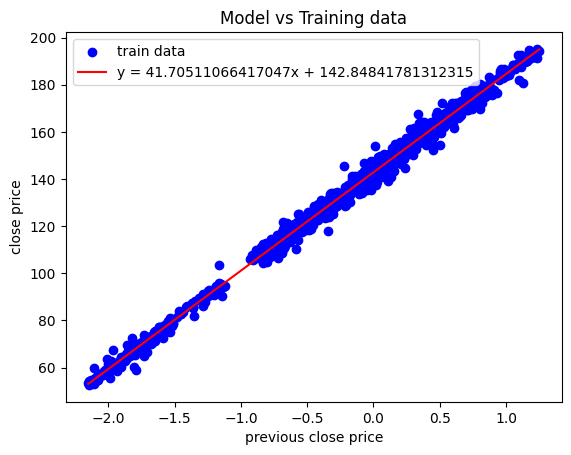

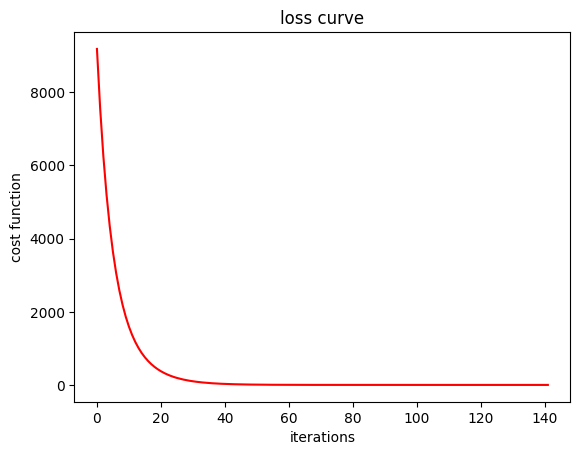

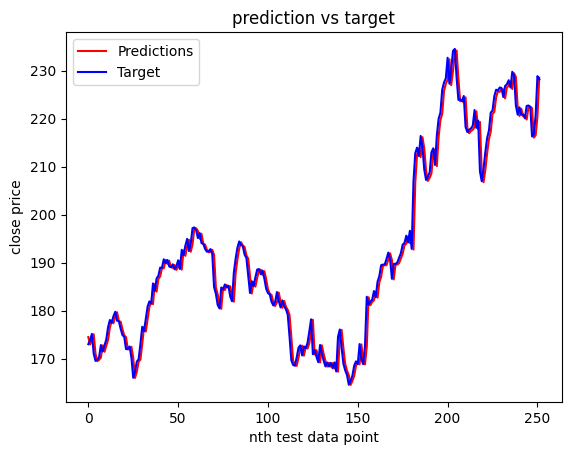

RMSE : 2.748506670881477


In [121]:
def main():
    ticker = yf.Ticker(TICKER)
    apple_share_price_data = ticker.history(period=PERIOD)

    close = apple_share_price_data.Close.dropna()

    df = pd.DataFrame({FEATURE: close[:len(close)-1].values, TARGET : close[1:].values})

    df[FEATURE] = z_score_normalization(df[FEATURE])
    train_df = df.iloc[:train_len(len(df))]
    test_df = df.iloc[train_len(len(df)):]

    cost_history, w,b = train(train_df, LEARNING_RATE)

    print(f"FINAL MODEL : {w} x + {b}")
    model_vs_train_data_plot(w,b,list(train_df[FEATURE]),list(train_df[TARGET]))
    loss_curve_plot(cost_history)
    predictions = predict(test_df, w, b)
    prediction_vs_actual_plot(predictions, list(test_df[TARGET]))
    print(f"RMSE : {rmse(predictions, list(test_df[TARGET]))}")

main()